In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import contractions

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

In [4]:
sentiment_df = pd.read_csv("dataset/Sentiment140.csv", header=None, encoding='ISO-8859-1')
sentiment_df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
sentiment_df

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anantha_padmanaban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anantha_padmanaban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anantha_padmanaban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
def preprocess_text(text):
    text = contractions.fix(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z\'\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_text)

In [ ]:
sentiment_df['cleaned_text'] = sentiment_df['text'].apply(preprocess_text)

sentiment_df.head()

In [6]:
def visualize_word_frequencies(dataframe, text_column='cleaned_text'):
    all_words = ' '.join(dataframe[text_column]).split()
    freq_dist = FreqDist(all_words)
    freq_dist.plot(30, cumulative=False)
    plt.show()

In [7]:
def analyze_tweet_lengths(dataframe, text_column='cleaned_text'):
    dataframe['tweet_length'] = dataframe[text_column].apply(lambda x: len(x.split()))
    plt.hist(dataframe['tweet_length'], bins=20)
    plt.title('Distribution of Tweet Lengths')
    plt.xlabel('Length of a tweet')
    plt.ylabel('Number of tweets')
    plt.show()

In [8]:
def create_sentiment_wordclouds(dataframe, sentiment_column='sentiment', text_column='cleaned_text'):
    positive_text = ' '.join(dataframe[dataframe[sentiment_column] == 4][text_column])
    negative_text = ' '.join(dataframe[dataframe[sentiment_column] == 0][text_column])
    def generate_wordcloud(text):
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

    print("Word Cloud for Positive Sentiments:")
    generate_wordcloud(positive_text)
    print("Word Cloud for Negative Sentiments:")
    generate_wordcloud(negative_text)

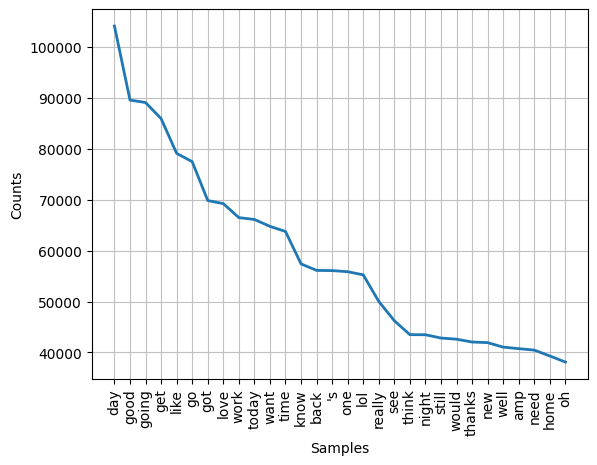

In [9]:
visualize_word_frequencies(sentiment_df)

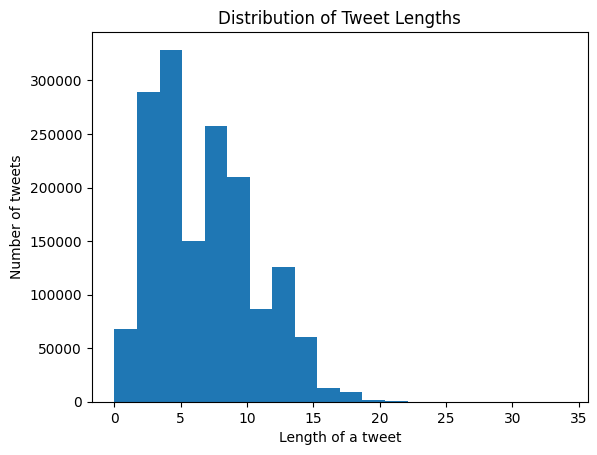

In [10]:
analyze_tweet_lengths(sentiment_df)

Word Cloud for Positive Sentiments:


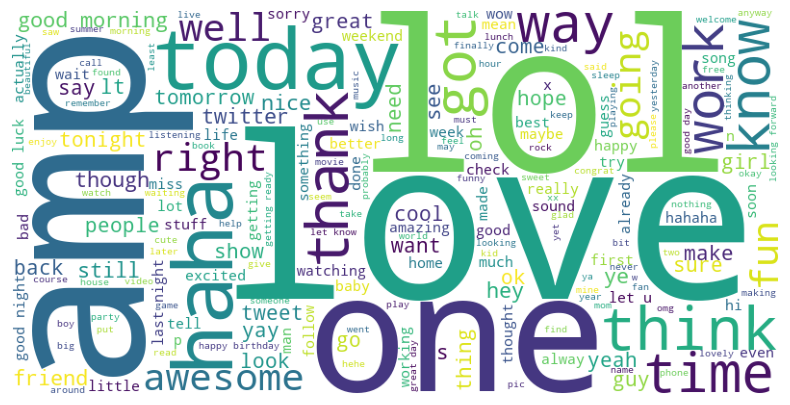

Word Cloud for Negative Sentiments:


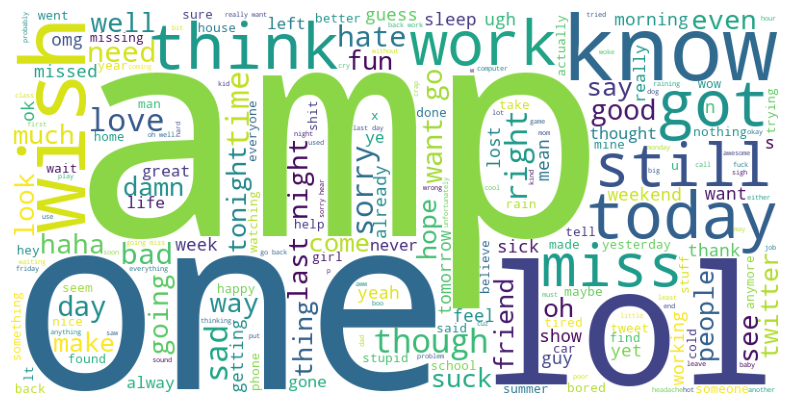

In [11]:
create_sentiment_wordclouds(sentiment_df)

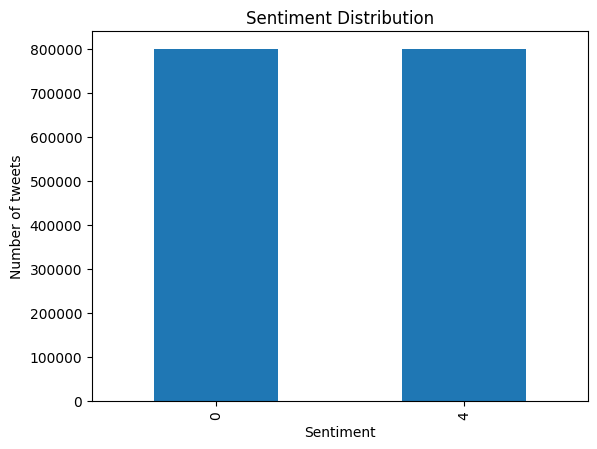

In [12]:
sentiment_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.show()

In [15]:
import gensim.downloader as api
word_vectors = api.load("word2vec-google-news-300")

In [16]:
def vectorize_text(text, word_vectors):
    word_vecs = [word_vectors[word] for word in text.split() if word in word_vectors]
    if len(word_vecs) == 0:
        return np.zeros(word_vectors.vector_size)
    else:
        return np.mean(word_vecs, axis=0)

In [17]:
sentiment_df['feature_vector'] = sentiment_df['cleaned_text'].apply(lambda x: vectorize_text(x, word_vectors))

In [18]:
sentiment_df

,sentiment,id,date,query,user,text,cleaned_text,tweet_length,feature_vector
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",bummer shoulda got david carr third day,7,"[0.03390067, 0.004673549, -0.06705148, 0.18673..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,11,"[0.060835406, -0.03318648, 0.01827448, 0.06874..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound,9,"[0.080552846, 0.0723354, -0.0027737087, 0.0754..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire,6,"[0.10814413, 0.030995687, 0.033276875, 0.08703..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving mad see,3,"[0.0065104165, 0.045288086, 0.021341959, 0.152..."
...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,woke school best feeling ever,5,"[-0.010546875, 0.05119629, 0.078125, 0.0146484..."
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom cool hear old walt interview,6,"[0.12056275, 0.002734375, 0.026660156, 0.00791..."
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask detail,5,"[0.07386474, 0.14440918, 0.025927734, -0.05615..."
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...,9,"[-0.0006626674, 0.048191614, 0.066331044, 0.17..."


In [19]:

X = np.array(sentiment_df['feature_vector'].tolist())

y = sentiment_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.73


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_bow = vectorizer.fit_transform(sentiment_df['cleaned_text'])

In [26]:
from sklearn.metrics import accuracy_score, classification_report
y = sentiment_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.77


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(sentiment_df['cleaned_text'])

In [15]:
y = sentiment_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.77


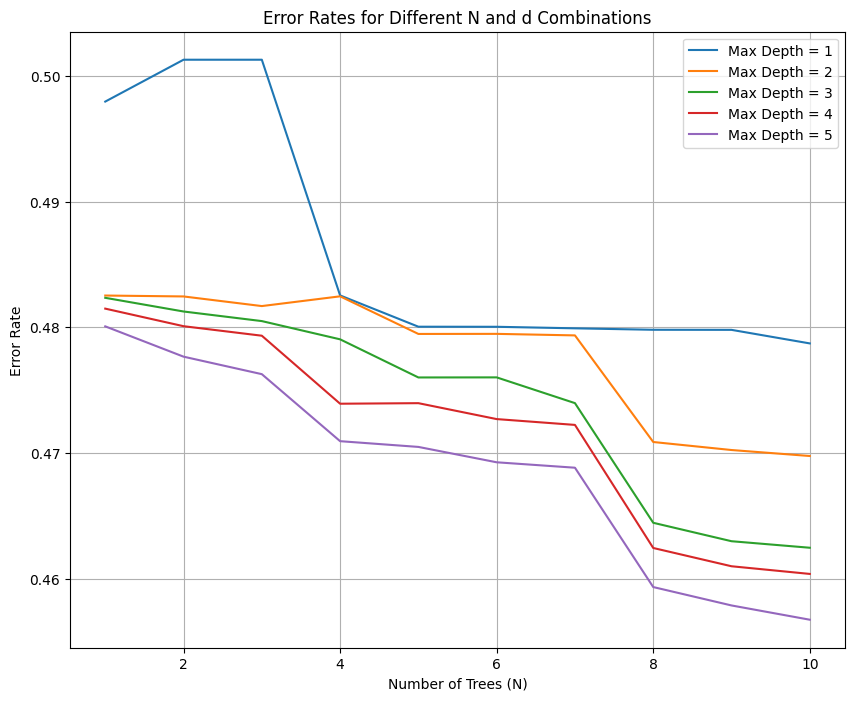

In [16]:
N = range(1, 11)
D = range(1, 6)
error_rates = np.zeros((len(N), len(D)))

for i, n in enumerate(N):
    for j, d in enumerate(D):
        model = RandomForestClassifier(n_estimators=n, max_depth=d, criterion='entropy', random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        error_rate = 1 - accuracy_score(y_test, predictions)
        error_rates[i, j] = error_rate

plt.figure(figsize=(10, 8))
for i, d in enumerate(D):
    plt.plot(N, error_rates[:, i], label=f'Max Depth = {d}')
plt.xlabel('Number of Trees (N)')
plt.ylabel('Error Rate')
plt.title('Error Rates for Different N and d Combinations')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
min_error_index = np.unravel_index(np.argmin(error_rates, axis=None), error_rates.shape)
optimal_N = N[min_error_index[0]]
optimal_d = D[min_error_index[1]]
optimal_error_rate = error_rates[min_error_index]

optimal_N, optimal_d, optimal_error_rate

(10, 5, 0.456753125)

In [19]:
RandonForest = RandomForestClassifier(n_estimators=optimal_N, max_depth=optimal_d, random_state=42)
RandonForest.fit(X_train, y_train)
RandonForest_predictions = RandonForest.predict(X_test)

RandonForest_accuracy = accuracy_score(y_test, RandonForest_predictions)
RandonForest_confussion = confusion_matrix(RandonForest_predictions, y_test)

RandonForest_TN = RandonForest_confussion[0, 0]  # True Negatives
RandonForest_FP = RandonForest_confussion[0, 1]  # False Positives
RandonForest_FN = RandonForest_confussion[1, 0]  # False Negatives
RandonForest_TP = RandonForest_confussion[1, 1]  # True Positives

RandonForest_truePositiveRate = RandonForest_TP / (RandonForest_TP + RandonForest_FN)
RandonForest_trueNegativeRate = RandonForest_TN / (RandonForest_TN + RandonForest_FP)

RandonForest_PerformanceMeasure = {
    "classifier" : ["Randon Forest"],
    'TP': [RandonForest_TN],
    'FP': [RandonForest_FP],
    'TN': [RandonForest_FN],
    'FN': [RandonForest_TP],
    'accuracy': [round(RandonForest_accuracy, 3)*100],
    'TPR': [round(RandonForest_truePositiveRate, 3)],
    'TNR': [round(RandonForest_trueNegativeRate, 3)]
}

RandonForest_PerformanceMeasure = pd.DataFrame(RandonForest_PerformanceMeasure)
RandonForest_PerformanceMeasure

,classifier,TP,FP,TN,FN,accuracy,TPR,TNR
0,Randon Forest,27760,14280,131734,146226,54.4,0.526,0.66


In [ ]:
logisticRegression = LogisticRegression(max_iter=1000)
logisticRegression.fit(X_train, y_train)

logisticRegression_predictions = logisticRegression.predict(X_test)
logisticRegression_accuracy = accuracy_score(logisticRegression_predictions, y_test)

logisticRegression_confussion = confusion_matrix(logisticRegression_predictions, y_test)

logisticRegression_TN = logisticRegression_confussion[0, 0]
logisticRegression_FP = logisticRegression_confussion[0, 1] 
logisticRegression_FN = logisticRegression_confussion[1, 0]
logisticRegression_TP = logisticRegression_confussion[1, 1] 

logisticRegression_truePositiveRate = logisticRegression_TP / (logisticRegression_TP + logisticRegression_FN)
logisticRegression_trueNegativeRate = logisticRegression_TN / (logisticRegression_TN + logisticRegression_FP)


logisticRegression_PerformanceMeasure = {
    "classifier" : ["Logistic Regression"],
    'TP': [logisticRegression_TN],
    'FP': [logisticRegression_FP],
    'TN': [logisticRegression_FN],
    'FN': [logisticRegression_TP],
    'accuracy': [round(logisticRegression_accuracy, 3)*100],
    'TPR': [round(logisticRegression_truePositiveRate, 3)*100],
    'TNR': [round(logisticRegression_trueNegativeRate, 3)*100]
}

logisticRegression_PerformanceMeasure = pd.DataFrame(logisticRegression_PerformanceMeasure)
logisticRegression_PerformanceMeasure

In [ ]:
classifier_df = pd.concat([logisticRegression_PerformanceMeasure, RandonForest_PerformanceMeasure], ignore_index=True)
classifier_df